In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2
import sscCdi

%matplotlib widget

In [ ]:
path = "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/glass_sphere/temp/2023-05-16-15h38m_glass_sphere_phase_cropped_sinogram.npy"
data = np.load(path)[0:10]

path = "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/glass_sphere/2023-05-16-15h38m_glass_sphere.hdf5"
data = h5py.File(path,'r')['recon/object'][()][:,1400:-1400,1400:-1550]

frame = data[0]
frame.shape

In [ ]:
# sscCdi.misc.deploy_visualizer(data,title='sample',cmap='gray')

In [ ]:
def calculate_local_variance_field(matrix):
    
    gradient = np.gradient(frame)
    del_x = gradient[1]
    del_y = gradient[0]
        
    return np.sqrt(np.abs(del_x)**2 + np.abs(del_y)**2)

local_variance = calculate_local_variance_field(frame)

fig, ax = plt.subplots(1,2)
ax[0].imshow(np.abs(frame))
ax[1].imshow(local_variance)

In [20]:
def get_gaussian_pyramid(frame,layers=2):

    from skimage.transform import pyramid_gaussian

    img_real = np.real(frame)
    img_imag = np.imag(frame)

    pyramid_real = tuple(pyramid_gaussian(img_real,downscale=2,max_layer=layers-1))
    pyramid_imag = tuple(pyramid_gaussian(img_imag,downscale=2,max_layer=layers-1))
    
    pyramid = []
    for R, I in zip(pyramid_real,pyramid_imag):
        pyramid.append(R+1j*I)

    return pyramid

pyramid = get_gaussian_pyramid(frame)

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft

shift, error, diffphase = phase_cross_correlation(image, offset_image, upsample_factor=100)

Known offset (y, x): (-22.4, 13.32)


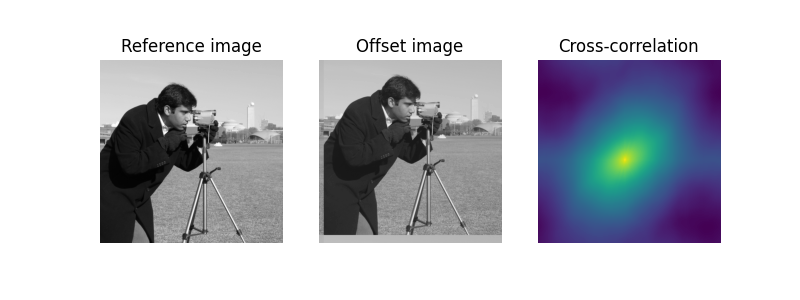

Detected pixel offset (y, x): [ 22. -13.]


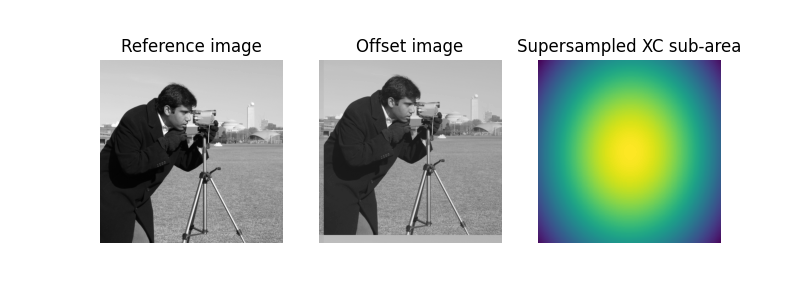

Detected subpixel offset (y, x): [ 22.4  -13.32]


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

image = data.camera()
shift = (-22.4, 13.32)
# The shift corresponds to the pixel offset relative to the reference image
offset_image = fourier_shift(np.fft.fftn(image), shift)
offset_image = np.fft.ifftn(offset_image)
print(f'Known offset (y, x): {shift}')

# pixel precision first
shift, error, diffphase = phase_cross_correlation(image, offset_image)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print(f'Detected pixel offset (y, x): {shift}')

# subpixel precision
shift, error, diffphase = phase_cross_correlation(image, offset_image,
                                                  upsample_factor=100)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print(f'Detected subpixel offset (y, x): {shift}')

In [ ]:
def shift_2d_replace(data, dx, dy, constant=False):
    """
    Shifts the array in two dimensions while setting rolled values to constant
    :param data: The 2d numpy array to be shifted
    :param dx: The shift in x
    :param dy: The shift in y
    :param constant: The constant to replace rolled values with
    :return: The shifted array with "constant" where roll occurs
    """
    shifted_data = np.roll(data, dx, axis=1)
    if dx < 0:
        shifted_data[:, dx:] = constant
    elif dx > 0:
        shifted_data[:, 0:dx] = constant

    shifted_data = np.roll(shifted_data, dy, axis=0)
    if dy < 0:
        shifted_data[dy:, :] = constant
    elif dy > 0:
        shifted_data[0:dy, :] = constant
    return shifted_data

# scipy.ndimage.shift